# Short Time Fourier Transform (STFT)

In this notebook, we provide a hands-on tutorial and overview about the _Short Time Fourier Transform_ (STFT). In real-time processing, an STFT engine is essential if any frequency-domain application is to be performed.

Here's the outline of this notebook:

1. [Why frequency domain processing?](#why)
2. [Time-frequency analysis with the STFT](#analysis)
3. [Frequency-domain processing](#processing)
4. [Real-time analysis and processing](#real-time)
5. [Magnitude modifications in the STFT domain: noise suppresion](#noise-suppression)
6. [Phase modifications in the STFT domain: filtering](#filtering)

First some imports!

In [1]:
import IPython
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import matplotlib
import pyroomacoustics as pra
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15

And some utility functions for this notebook.

In [2]:
def plot_spec(spec, t_audio, frame_len, fs, hop=None):
    
    if hop is None:
        hop = frame_len
        
    fig, ax = plt.subplots(figsize=(20,7))
    spec = np.swapaxes(spec, 0 ,1)
    cax = ax.imshow(spec, interpolation=None, origin='lower', aspect='auto')
    ax.set_xlabel("Time [seconds]", fontsize=30)
    ax.set_ylabel("Frequency [Hz]", fontsize=30)
    x_labels = np.arange(max(t_audio), step=0.5)
    plt.xticks(x_labels*fs//hop, x_labels, fontsize=20)
    freqs = np.arange(frame_len//2+1) / frame_len * fs
    y_labels = np.arange(max(freqs)+1, step=1000).astype(np.int)
    plt.yticks(y_labels//(fs/frame_len), y_labels, fontsize=20)
    plt.tight_layout()

<a id='why'></a>
## Why frequency domain processing?

We are often interested in what frequency content is present in a signal, as it can provide insight into what type of signals are present. Such an analysis could help us distinguise unique sources and even suppress undesirable ones with the appropriate processing!

For the purposes of frequency analysis, we rely on the _Discrete Fourier Transform_ (DFT). The DFT of a signal will yield a _frequency spectrum_, allowing us to identify key frequency components in a signal. Below we take the DFT of a signal containing speech.

**Note:** we plot the frequency in log scale and the amplitudes are computed in _decibels_, namely: $20 \log_{10} ( |X(f)|) $.

Number of samples / FFT length : 57040
Duration of input : 3.565000 seconds
Sampling rate : 16000 Hz


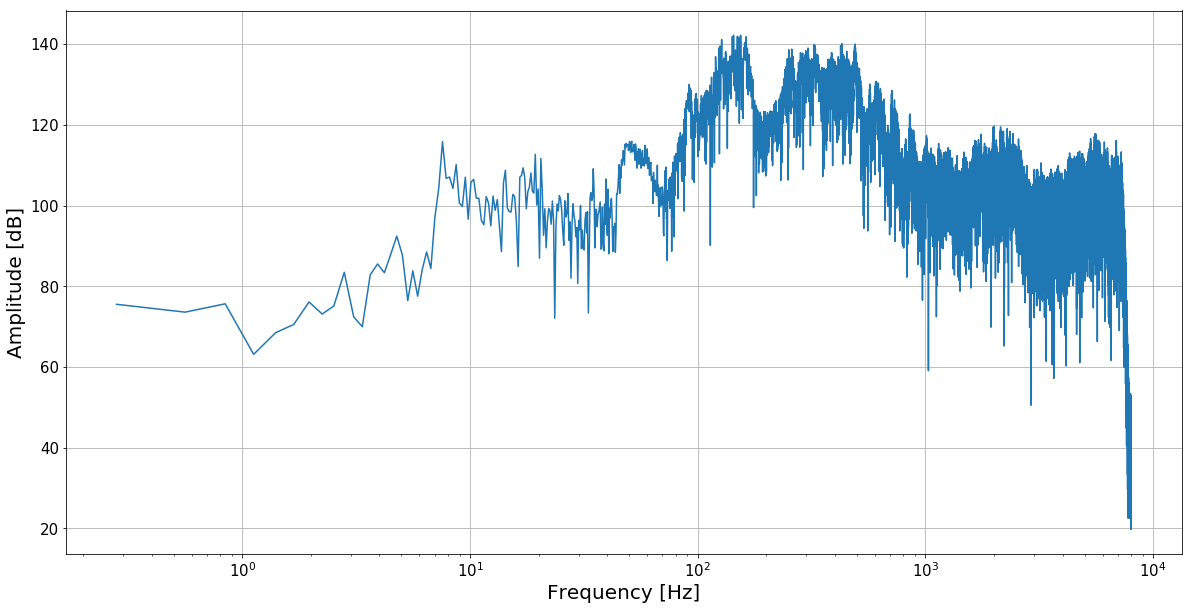

In [3]:
# load WAV file and take real FFT
fs, audio = wavfile.read("arctic_a0010.wav")
X = np.fft.rfft(audio)
print("Number of samples / FFT length : %d" % (len(audio)))
print("Duration of input : %f seconds" % (len(audio)/fs))
print("Sampling rate : %d Hz" % fs)

# visualize spectrum
freqs = np.arange(len(X)) / len(audio) * fs
plt.figure(figsize=(20,10))
plt.semilogx(freqs, pra.dB(X))
# plt.plot(freqs, pra.dB(X))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.grid()

We can see that most of the energy is concentrated within $100-1000$ Hz, as is characteristic of voice. 


<a id='analysis'></a>
## Time-frequency analysis with the STFT
In the above example, we computed the spectrum over the entire audio signal, namely $57'040$ samples. This corresponds to $3.57$ seconds for the sampling rate of $16$ kHz. If performing real-time analysis, waiting for this many samples in order to perform frequency analysis (and further processing) would incur way too much latency!

For real-time frequency analysis (and processing), we will therefore have to work with much less samples, on the order of $20-40$ milliseconds so that the delay is not noticeable for human hearing. However, using less samples / a shorter FFT results in a "poorer" frequency resolution. In other words, we have a tradeoff between _temporal_ and _frequency_ resolution. You can read more about this [here](https://electronics.stackexchange.com/questions/12407/what-is-the-relation-between-fft-length-and-frequency-resolution/12412#12412).

We will call a small chunk of $20-40$ milliseconds a _frame_. By performing the frequency analysis of consecutive frames, we can form a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), visualizing how frequency content varies over time.

Below we build a spectrogram using a frame length of $512$ samples ($32$ milliseconds at $16$ kHz). A frame length of $512$ is selected because computing the DFT for lengths that are powers of $2$ is more efficient.

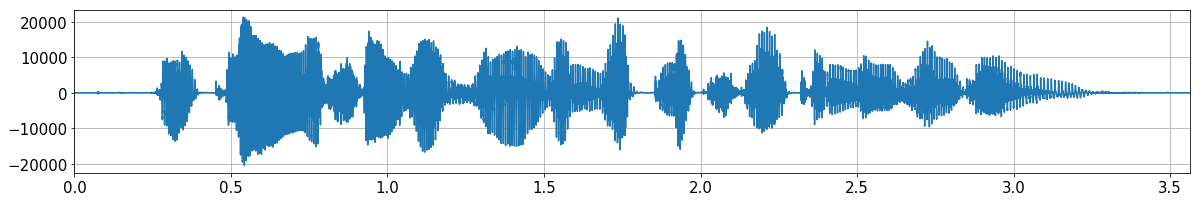

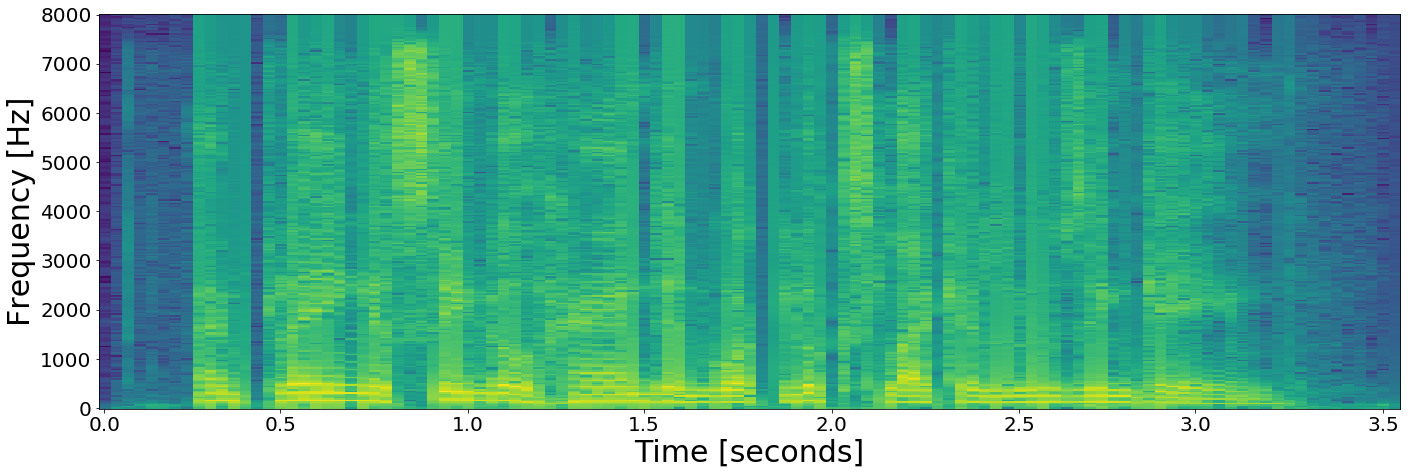

In [4]:
frame_len = 512
X = pra.stft(audio, L=frame_len, hop=frame_len, transform=np.fft.rfft)
spec = pra.dB(X)  
    
# visualize
t_audio = np.arange(len(audio))/fs
plt.figure(figsize=(20,3))
plt.plot(t_audio, audio)
plt.xlim(0, max(t_audio))
plt.grid()

plot_spec(spec, t_audio, frame_len, fs)

In the above visualization, we can observe the time waveform and the corresponding spectrogram. We can notice higher energy in the spectrogram (yellow) when we have more activity in the waveform. 

<a id='processing'></a>
## Frequency-domain processing with the STFT

So we've seen how to perform a time-frequency analysis of an input signal. Moreover, performing the DFT on consecutive frame allows us to analyze the frequency components of a signal in a real-time fashion. What about performing processing in the frequency domain? For example, filtering out higher frequency components or suppressing noise in an adaptive fashion.

Let's start off with a super simple example, namely zero-ing all frequencies above a certain _cutoff_ value.

In [5]:
cutoff = 2000
cutoff_bin = int(cutoff/fs*frame_len)
X_lpf = X.copy()
X_lpf[:, cutoff_bin:] = 0

We can then recreate the time-domain signal by performing the _inverse DFT_ of each frame and concatenating the frames.

In [6]:
signal_lpf_naive = pra.istft(X_lpf, L=frame_len, hop=frame_len, transform=np.fft.irfft)

print("Naive LPF'ed signal:")
IPython.display.Audio(signal_lpf_naive, rate=fs)

Naive LPF'ed signal:


In [7]:
print("Original WAV:")
IPython.display.Audio(audio, rate=fs)

Original WAV:


The high frequencies are clearly removed as the voice sound very _muffled_ in the resulting output. **_BUT_** we have have this repetitive ticking sound! What is the source of this "mysterious ticking noise" ;)

Well it's no magic. What happens is that by performing spectral modifications and taking the inverse DFT, we may be introducing _discontinuities_ between consecutive frames. And these discontinuities appear as ticking sounds.

<div style="text-align:center"><img src ="figures/discontinuity.png" width="400"/></div>
<center><i>From lecture notes by Christof Faller and Dirk Schroeder for the course <a href="http://isa.epfl.ch/imoniteur_ISAP/!itffichecours.htm?ww_i_matiere=2380867301&ww_x_anneeacad=1866893861&ww_i_section=84482813&ww_i_niveau=2936286&ww_c_langue=fr">Audio and acoustic signal processing</a>.</i></center>

The technique for avoiding such discontinuities avoid "hard" boundaries between consecutive frames, namely:
1. Process overlapping buffers.
2. Apply windowing in order to fade in/out between frame.

It is common practice to have $ 50\% $ overlap between consecutive frames.  

The windowing can be performed at _analysis_ (before performing the DFT) and/or at _synthesis_ (after performing the inverse DFT). The analysis and synthesis windows should be selected so that the input and output signal are equal if no spectral modification is performed.

A popular pair of window functions for $50\%$ overlap is the _Rectangular_ (all-ones) / [_Hanning_](https://en.wikipedia.org/wiki/Hann_function) pair. Let's try it out with our naive filter!

In [8]:
frame_len = 512
hop = frame_len//2
synthesis_window = pra.hann(frame_len)

# analysis
X_overlap = pra.stft(audio, L=frame_len, hop=hop, transform=np.fft.rfft)

# LPF
X_overlap[:, cutoff_bin:] = 0

signal_lpf_naive = pra.istft(X_overlap, L=frame_len, hop=hop, transform=np.fft.irfft, win=synthesis_window)

print("Naive LPF'ed signal:")
IPython.display.Audio(signal_lpf_naive, rate=fs)

Naive LPF'ed signal:


The repetitive ticking is noticeably reduced! We may, however, hear some ringing artefacts (try with headphones) from using a filter with such a sharp cutoff (see [Gibb's phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon)).

<a id='real-time'></a>
## Real-time analysis and processing with the STFT

Before looking at more realistic and interesting examples, let's look into how the analysis and synthesis steps are performed. This will shed some light on some practical considerations that need to be taken into account when using the STFT for real-time frequency processing. With the above "one-shot" functions from `pyroomacoustics`, the analysis (framing + windowing + DFT) and synthesis (inverse DFT + windowing + overlap-and-add) are performed on an entire input signal. 

In `pyroomacoustics`, there are also functionalities to perform the STFT and processing with a _streaming_ input signal. The internal workings are a bit difficult to parse as they deal with different use cases, but we will go through the necessary implementation here with a simple example and signal.

In a real-time scenario we will not have our entire signal all at once, but rather receive it in _buffers_, namely finite number of samples. We are usually able to chose the length of this buffer. Similarly, our processing should return buffers of the same length. 

In the context of the STFT, it is important to see how the following parameters affect each other:
1. The input/output buffer length $B$.
2. STFT frame length $F$.
3. STFT overlap $P$ (percentage) / $D$ (in samples).

#### Example 1: Desired FFT resolution and overlap

Let's say we want to perform an STFT with a frame length of $F = 512$ and an overlap of $P = 60\%$. A common assumption is that the $60\%$ overlap, _i.e._ $D = \text{ceil}(FP) = 308$ samples, between consecutive frames would be samples "available" at _both_ the current time instant when we are receiving $B$ samples and the previous time instant when we are also receiving $B$ samples. Therefore, at every buffer we should expect $B = F - D = 512-308 = 204$ samples so that we can build the frame of desired length $F$. Moreover, we would need to store $D=308$ samples between buffers.

#### Example 2: Desired FFT resolution and fixed buffer length

Let's say we want a frequency resolution with $F = 600$ bins but we are stuck with an input/output buffer of $B = 400$ samples. If we are to use all new input buffer samples for the current frame, the overlap amount would amount to $P = (F-B)/F = 33\%$, _i.e._ $ D = 200$ samples. Moreover, we would need to store this many samples between buffers.

#### Example 3: Desired overlap and fixed buffer length

Following the same argument as the above examples, if we have a buffer length of $B=256$ samples and would like $ P = 50\%$ overlap between consecutive STFT frames, the STFT frame length is commonly set to $ F = B / (1 - P/100) = 512$ samples. Moreover, $D = \text{ceil}(FP) = 256$ samples would need to be stored between buffers.


#### Analysis implementation

The code snippet below simulates a streaming source from an input signal, reading $B = 256$ samples at a time.

/Users/eric/anaconda3/lib/python3.6/site-packages/pyroomacoustics/utilities.py:153: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(np.abs(signal))


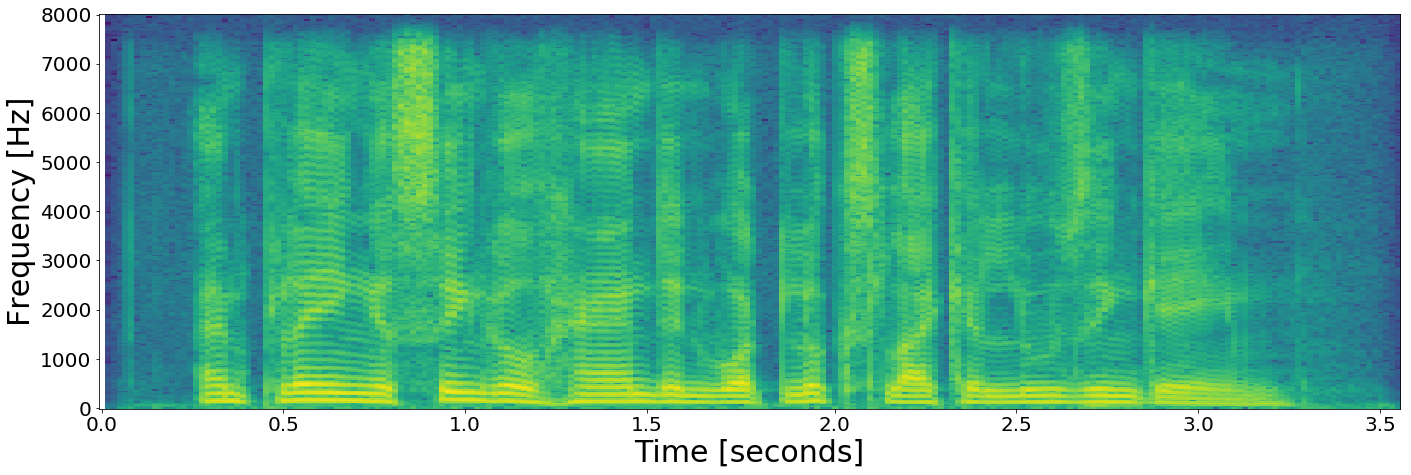

In [9]:
buffer_len = 256
overlap = 0.5
n = 0

# derived parameters
hop = buffer_len
frame_len = int(np.ceil(hop / (1 - overlap)))
window_analysis = pra.hann(frame_len)

# STFT input buffers
n_overlap_samp = frame_len-hop
dft_int = np.zeros(frame_len)
new_samples = dft_int[n_overlap_samp:]
old_samples = dft_int[hop:]

x_p = np.zeros(frame_len - buffer_len)

# simulate streaming input
spec = []
while len(audio) - n > hop:
    
    buffer = audio[n:n+hop]
    
    # analysis step
    new_samples[:] = buffer
    X = np.fft.rfft(window_analysis * dft_int)
    dft_int[:n_overlap_samp] = old_samples
    
    # collect DFTs to see spectrogram for debugging
    spec.append(pra.dB(X))
    n+= hop
    
plot_spec(np.array(spec), t_audio, frame_len, fs, hop=hop)    

Now to go back to the time-domain, we need to perform an operation called _overlap-and-add_. As a reminder, we are overlapping two frames and adding their contributions in order to avoid discontinuities between consecutive frames. Moreover, recalling our real-time processing constraint, we must have the same number of samples in the input and output buffer.

There are two cases we need to consider in the synthesis step when adding and storing samples for the next buffer:
1. Overlap $\leq 50\%$
2. Overlap $> 50\%$

#### Overlap < 50% ==> buffer / hop size larger than overlap amount

This is the simpler case in which all samples stored from the previous frame will be used in the current output buffer. Below is a nice visualization taken from [Wikipedia](https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method). The frame length is denoted by $L$ and the buffer / hop size is such that we store $M$ samples (shaded) between frames for the overlap-and-add.

<div style="text-align:center"><img src ="figures/WIKI_depiction_of_overlap-add_algorithm.png" width="600"/></div>
<center><i>Overlap-and-add for less than 50% overlap.</i></center>

#### Overlap > 50%  ==> buffer / hop size less than overlap amount

In this case, a bit more planning is required because we _will not_ be using all samples from the previous frame in the current output. In fact, we will have to keep samples for possibly multiple buffers in the future!

It is not common to have so much overlap; nonetheless, it's a good exercise in understanding overlap-and-add and how samples need to be shared between buffers. Below is a visualization of a scenario in which we have more than $50\%$ overlap.

<div style="text-align:center"><img src ="figures/overlap_and_add_75.jpg" width="300"/></div>
<center><i>Overlap-and-add for more than 50% overlap.</i></center>

As we can see from the figure above, more than two buffers overlap in order to create the current buffer's output. If our buffer / hop size is $B$, the first $B$ samples stored from the previous buffer (e.g. shaded region of $y_0(t)$ for $y_1(t)$) will overlap and add with the first $B$ samples of the current frame in order to create the buffer output. Moreover, the remaining $ L-2B $ samples saved from the previous buffer will overlap and add with $L-2B$ samples (after $B$ samples) of the current frame and stored for the next buffer. The last $B$ samples of the current frame will not overlap with any of the samples saved from the previous buffer, but still need to be stored for the next buffer.

The above explanation is quite dense, so do take care to read through it carefully and refer to the figure above! In any case, such a scenario of more than $50\%$ is quite uncommon. In most of the scenarios, you will be working with $50\%$ overlap or less.

#### Analysis + synthesis implementation

From the code snippet above, we add the synthesis step and ensure that the input and ouput closely match.

MSE : 0.000755
STFT passthrough:


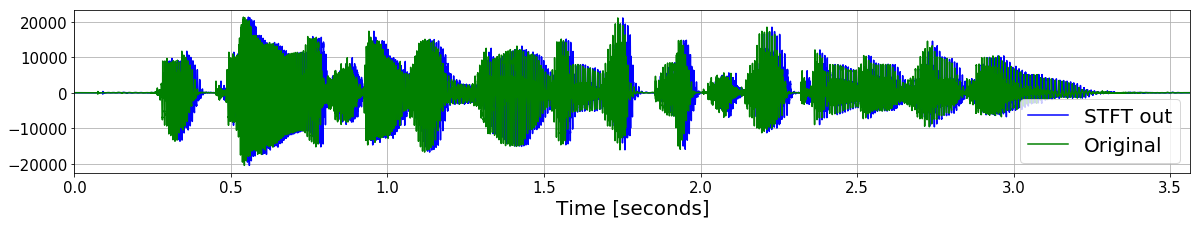

In [10]:
buffer_len = 256
overlap = 0.5
n = 0

# derived parameters
hop = buffer_len
frame_len = int(np.ceil(hop / (1 - overlap)))
window_analysis = pra.hann(frame_len)
window_synthesis = np.ones(frame_len)

# STFT input buffers
n_overlap_samp = frame_len-hop
dft_in = np.zeros(frame_len)
new_samples = dft_in[n_overlap_samp:]
old_samples = dft_in[hop:]
dft_out = np.zeros(frame_len//2+1, dtype=np.complex)

# STFT output buffers
idft_out = np.zeros(frame_len)
current_out = np.zeros(hop)
prev_out = np.zeros(n_overlap_samp)

x_p = np.zeros(frame_len - buffer_len)

# simulate streaming input
audio_proc = np.zeros(audio.shape)
while len(audio) - n > hop:
    
    buffer = audio[n:n+hop]
    
    # analysis step
    new_samples[:] = buffer
    dft_out[:] = np.fft.rfft(window_analysis * dft_in)
    dft_in[:n_overlap_samp] = old_samples
    
    # synthesis step
    idft_out[:] = window_synthesis * np.fft.irfft(dft_out)
    current_out[:] = idft_out[:hop]
    if n_overlap_samp > 0:
        if hop >= n_overlap_samp:
            current_out[:n_overlap_samp] += prev_out[:n_overlap_samp]
            prev_out[:] = idft_out[hop:]
        else:
            current_out[:] += prev_out[:hop]
            prev_out[:-hop] = prev_out[hop:]   # shift left
            prev_out[-hop:] = 0.
            prev_out[:] += idft_out[hop:]
        
    # store processed signal
    audio_proc[n:n+hop] = current_out
    n+= hop
    
# check close match
t_audio = np.arange(len(audio))/fs
plt.figure(figsize=(20,3))
plt.plot(t_audio, audio_proc, 'b', label='STFT out')
plt.plot(t_audio, audio, 'g', label='Original')
plt.grid()
plt.xlim(0, max(t_audio))
plt.xlabel("Time [seconds]")
plt.legend()

# compute MSE, keep in mind delay in STFT output
err = audio[:-hop] - audio_proc[hop:]
print("MSE : %f" % (np.linalg.norm(err)/len(err)))

print("STFT passthrough:")
IPython.display.Audio(audio_proc, rate=fs)

Notice the delay in the STFT output due to using the samples from the previous buffer to build the current frame. The delay is precisely the buffer / hop size. 

When we align the STFT output and the original signal and compute the _mean squared error_ (MSE), the value is acceptably low. And from "audible inspection" the signal sounds unaltered after going through the STFT!

In the code snippet below, we perform the same STFT passthrough using `pyroomacoustics` functionatlities. 

In [11]:
# STFT parameters
fft_len = 512
hop = fft_len // 2  # half overlap
window = pra.hann(fft_len, flag='asymmetric', length='full') 

# create the STFT object
stft = pra.transform.STFT(fft_len, hop=hop, analysis_window=window)

# simulate streaming input
processed_audio = np.zeros(audio.shape)
n = 0
while len(audio) - n > hop:
    stft.analysis(audio[n:n+hop])
    processed_audio[n:n+hop] = stft.synthesis()
    n += hop
    
# compute MSE, keep in mind delay in STFT output
err = audio[:-hop] - processed_audio[hop:]
print("MSE : %f" % (np.linalg.norm(err)/len(err)))

MSE : 0.000755


<a id='noise-suppression'></a>
## Noise suppression in the STFT domain

Now that we know how to perform real-time processing in the STFT domain, let's look into our first application: _noise suppression_.

We will implement a noise suppressor that relies on the spectral subtraction technique. The approach tries to determine "how much" of each frequency bin correspond to noise and uses a mask to attenuate those bins deemed as too noisy. Algorithmically, we will be performing _Magnitude Modifications_ in the STFT domain.

You can see a block diagram of the approach in the figure below. The algorithm is described in detail in the lecture notes of the [Audio and acoustic signal processing](http://isa.epfl.ch/imoniteur_ISAP/!itffichecours.htm?ww_i_matiere=2380867301&ww_x_anneeacad=1866893861&ww_i_section=84482813&ww_i_niveau=2936286&ww_c_langue=fr), in the STFT chapter.

<div style="text-align:center"><img src ="figures/noise_suppressor_stft.png" width="500"/></div>
<center><i>From lecture notes by Christof Faller and Dirk Schroeder for the course <a href="http://isa.epfl.ch/imoniteur_ISAP/!itffichecours.htm?ww_i_matiere=2380867301&ww_x_anneeacad=1866893861&ww_i_section=84482813&ww_i_niveau=2936286&ww_c_langue=fr">Audio and acoustic signal processing</a>.</i></center>

We will first create an articifial noisy signal by combining a clean speech file and a noise file at a specified SNR.

In [12]:
snr = 5         # SNR of input signal
speech_file = "arctic_a0010.wav"
noise_file = "exercise_bike.wav"

# load WAV files, should have same sampling rates!
fs_s, audio = wavfile.read(speech_file)
fs_n, noise = wavfile.read(noise_file)

# truncate to same length
noise = noise[:len(audio)]

# weight noise according to desired SNR
signal_level = np.linalg.norm(audio)
noise_level = np.linalg.norm(noise)
noise_fact = signal_level / 10**(snr/20)
noise_weighted = noise*noise_fact/noise_level

# add signal and noise
noisy_signal = audio + noise_weighted
noisy_signal /= np.abs(noisy_signal).max()
noisy_signal -= noisy_signal.mean()

print("Noisy speech:")
IPython.display.Audio(noisy_signal, rate=fs)

Noisy speech:


/Users/eric/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Now we will use the same `STFT` class from the `pyroomacoustics` library and also the `SpectralSub` class from the `denoise` sub-module.

In [13]:
# STFT and SpectralSub parameters
nfft = 512      # STFT frame length will be nfft/2 as we will use an STFT with 50% overlap.
db_reduc = 10   # Maximum suppression per frequency bin. Large suppresion can result in more musical noise.
lookback = 5    # How many frames to look back for the noise floor estimate.
beta = 10       # An overestimation factor to "push" the suppression towards db_reduc.
alpha = 3       # An exponential factor to tune the suppresion (see documentation of 'SpectralSub').
window = pra.hann(nfft, flag='asymmetric', length='full')

# create objects
stft = pra.transform.STFT(nfft, hop=nfft // 2, analysis_window=window)
scnr = pra.denoise.SpectralSub(nfft, db_reduc, lookback, beta, alpha)

And now we can simulate the streaming input and apply the spectral subtraction approach for noise suppression.

In [14]:
# collect the processed blocks
processed_audio = np.zeros(noisy_signal.shape)
n = 0
while noisy_signal.shape[0] - n > hop:

    # SCNR in frequency domain
    stft.analysis(noisy_signal[n:(n+hop)])
    gain_filt = scnr.compute_gain_filter(stft.X)

    # back to time domain
    processed_audio[n:n+hop] = stft.synthesis(gain_filt*stft.X)

    # update step
    n += hop
    
print("Denoised speech:")
IPython.display.Audio(processed_audio, rate=fs)

Denoised speech:


By playing with the parameters of the spectral subtraction approach, we can notice a tradeoff between [musical noise](https://www.vocal.com/noise-reduction/musical-noise/) and noise suppression. For example, with a larger `db_reduc`, we get more noise suppression but more musical noise (listen below).

In [15]:
# STFT and SpectralSub parameters
nfft = 512      # STFT frame length will be nfft/2 as we will use an STFT with 50% overlap.
db_reduc = 20   # Maximum suppression per frequency bin. Large suppresion can result in more musical noise.
lookback = 5    # How many frames to look back for the noise floor estimate.
beta = 10       # An overestimation factor to "push" the suppression towards db_reduc.
alpha = 3       # An exponential factor to tune the suppresion (see documentation of 'SpectralSub').
window = pra.hann(nfft, flag='asymmetric', length='full')

# create objects
stft = pra.transform.STFT(nfft, hop=nfft // 2, analysis_window=window)
scnr = pra.denoise.SpectralSub(nfft, db_reduc, lookback, beta, alpha)

# collect the processed blocks
processed_audio = np.zeros(noisy_signal.shape)
n = 0
while noisy_signal.shape[0] - n > hop:

    # SCNR in frequency domain
    stft.analysis(noisy_signal[n:(n+hop)])
    gain_filt = scnr.compute_gain_filter(stft.X)

    # back to time domain
    processed_audio[n:n+hop] = stft.synthesis(gain_filt*stft.X)

    # update step
    n += hop
    
print("Denoised speech:")
IPython.display.Audio(processed_audio, rate=fs)

Denoised speech:


<a id='filtering'></a>
## Filtering in the STFT domain

Perhaps we want to perform some sort of filtering in the STFT domain, either attenuate certain frequencies or spatial filtering (beamforming). In the time domain, such filtering corresponds to convolving our input signal with a certain impulse response that (typically) performs a linear combination of current and past samples.

Let's consider a super simple filter / impulse response that delays the input by $d$ samples. We can write this impulse response as:

$$
h[n] = \delta[n - d],
$$

where $\delta[n] = 1$ if $n=0$ and $0$ otherwise. The corresponding response at frequency bin $k$ is given by:

$$
H[k] = \exp(-\dfrac{j2\pi dk}{N}),
$$

where $N$ is the DFT length.

Imagine our current frame has a spike that is _less_ than $d$ samples to the left of the rightmost frame boundary. Applying such an impulse response will cause the spike to "wrap around" to the beginning of the frame!

Below an example in code to demonstrate this effect.

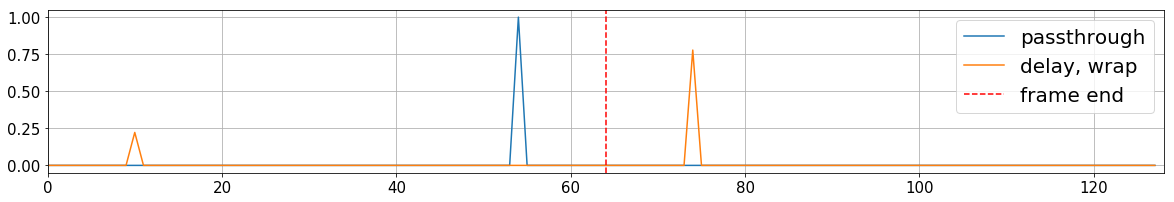

In [16]:
fft_len = 64
sig = np.zeros(2*fft_len)
d = 20
sig[fft_len//2-d//2] = 1

# create the STFT objects
hop = fft_len//2
analysis_window = pra.hann(fft_len, flag='asymmetric', length='full')

stft_pass = pra.transform.STFT(fft_len, hop=hop, analysis_window=analysis_window)
stft_delay = pra.transform.STFT(fft_len, hop=hop, analysis_window=analysis_window)

delay_stft = np.exp(-1j*2*np.pi*d*np.arange(hop+1)/fft_len)

# simulate streaming input
sig_pass = np.zeros(sig.shape)
sig_delay = np.zeros(sig.shape)
n = 0
while len(sig) - n > hop:
    
    buffer_in = sig[n:n+hop]
    
    # passthrough
    stft_pass.analysis(buffer_in)
    sig_pass[n:n+hop] = stft_pass.synthesis()
    
    # phase modification, wrap-around
    stft_delay.analysis(buffer_in)
    sig_delay[n:n+hop] = stft_delay.synthesis(stft_delay.X*delay_stft)
    
    n += hop

# visualized delayed output
plt.figure(figsize=(20,3))
plt.plot(sig_pass, label="passthrough")
plt.plot(sig_delay, label="delay, wrap")
plt.axvline(x=fft_len, label="frame end", c="r", linestyle="--")
plt.grid()
plt.legend()
plt.xlim([0,2*fft_len]);

In the above example, we can see some contribution of the spike _wrapping_ around to the beginning of the frame. This is known as _time-domain aliasing_.

What needs to be done is _zero-pad_ the frame, namely add zeros to the end of the frame, before performing the DFT so that the signal does not wrap around to the beginning. This can be done with the `STFT` module in `pyroomacoustics`, as shown below. The amount of zeros to pad should be the length of the filter _minus_ one. For non-causal processing, zeros would need to be padded to the beginning of the frame.

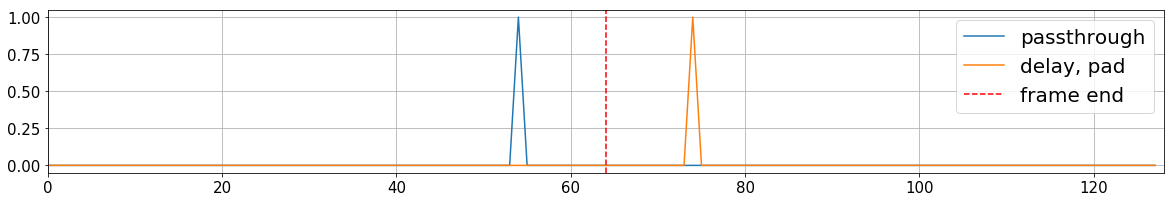

In [17]:
# define impulse response
h = np.zeros(d+1)
h[d] = 1
h /= np.linalg.norm(h)

# create STFT object with correct zero-padding and provide filter
stft_delay_zp = pra.transform.STFT(fft_len, hop=hop, analysis_window=analysis_window)
stft_delay_zp.set_filter(h, zb=h.shape[0]-1)

# phase modification with zero-padding
sig_delay_zp = np.zeros(sig.shape)
n = 0
while len(sig) - n > hop:
    
    stft_delay_zp.analysis(sig[n:n+hop])
    stft_delay_zp.process()   # call `process` to apply given filter
    sig_delay_zp[n:n+hop] = stft_delay_zp.synthesis()
    
    n += hop
    
# visualized delayed output
plt.figure(figsize=(20,3))
plt.plot(sig_pass, label="passthrough")
plt.plot(sig_delay_zp, label="delay, pad")
plt.axvline(x=fft_len, label="frame end", c="r", linestyle="--")
plt.grid()
plt.legend()
plt.xlim([0,2*fft_len]);

Voilà! No signal wraps around to the beginning of the frame :)

We can now try a more sophisticated filter. In the code snippet below, we apply a simple FIR low-pass filter.

In [18]:
from scipy import signal

fft_len = 512
cutoff = 1000
ntaps = 51

# load file
speech_file = "arctic_a0010.wav"
fs, audio = wavfile.read(speech_file)

# normalized cutoff
nyq = 0.5 * fs
fc_norm = cutoff / nyq

# design filter coefficients
h = signal.firwin(numtaps=ntaps, cutoff=fc_norm)

# create STFT object with correct zero-padding and provide filter
hop = fft_len // 2
analysis_window = pra.hann(fft_len, flag='asymmetric', length='full')
stft = pra.transform.STFT(fft_len, hop=hop, analysis_window=analysis_window)
stft.set_filter(h, zb=h.shape[0]-1)

# apply filter in STFT domain
sig_proc = np.zeros(audio.shape)
n = 0
while len(audio) - n > hop:
    
    stft.analysis(audio[n:n+hop])
    stft.process()   # call `process` to apply given filter
    sig_proc[n:n+hop] = stft.synthesis()
    
    n += hop
    
print("LPF'ed speech:")
IPython.display.Audio(sig_proc, rate=fs)

LPF'ed speech:


With this better-designed filter, we don't hear the undesirable ringing artifacts in the output that were present when using our previous filter that had a very sharp cutoff.